# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [128]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.plot_multi_analysis as pma
from src.optim import EvolutionnarySearch
import random

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [ ]:
# Define quota policy - determines how much water each actor is allowed to pump
# This uses the hard_quota policy from the quota_policies module
# In crisis situations, actors with priority below the crisis level get zero quota
import copy

class CrisisLevel:
    NORMAL = -1
    ALERT = 0
    CRISIS = 1
    EXTREME_CRISIS = 2

def tuned_make_quota_function(self, params):
    """
    Based on given parameters it generate a quota policy.

    Returns:
        func: Quota policy.
    """
    def tuned_quota(
        self,
        crisis_level: int,
        actors_priority: np.ndarray,
        avg_pump: np.ndarray,
        DOE: float,
        DCR: float,
        ) -> np.ndarray:
        """
        Hard quota policy based on priority and crisis level.
        
        Sets quotas to zero for actors with priority less than the current crisis level.
        
        Args:
            crisis_level: Current water crisis level.
            actors_priority: Priority levels for each actor.
            avg_pump: Average pumping for each actor.
            DOE: Ecological optimal flow threshold.
            DCR: Crisis flow threshold.
            
        Returns:
            Array of water quotas for each actor.
        """

        # This will make higher priority actors having bigger quotas
        priority_factor = copy.copy(actors_priority)

        priority_factor[priority_factor == 2] = params["PF"]
        priority_factor[priority_factor == 1] = params["PF"] - 1.8 **params["PG"]
        priority_factor[priority_factor == 0] = params["PF"] - 2.5 ** params["PG"]
        
        # print("crisis_level", crisis_level)
        if crisis_level == CrisisLevel.NORMAL:
            # Actors will be assigned quotas aligned with their priority
            # This will help us evaluate cooperation within incentive policy
            return (avg_pump * priority_factor)
        
        else:
            # Crisis times we estimate the available water and we distribute it according to the priority of the actors 
            # Until it reach the ecological acceptable flow
            maximum_amount = 0.0

            match crisis_level:
                case CrisisLevel.ALERT:
                    maximum_amount = DOE 
                case CrisisLevel.CRISIS:
                    maximum_amount = (DOE + DCR) / 2 
                case CrisisLevel.EXTREME_CRISIS:
                    # When already bellow the ecological flow, we don't want anyone to pump
                    return np.zeros_like(avg_pump)

            estimated_flow =  maximum_amount * params["WF_EF"]

            # Repartition by actor priority
            # Sort actors by priority, get indices
            sorted_indices = np.argsort(-actors_priority)
            quotas = np.zeros_like(avg_pump)

            for idx in sorted_indices:
                if estimated_flow <= DCR:
                    # If the remaining water is less than DCR, stop allocating, default value already 0
                    break
                pump = (avg_pump[idx] * 
                        params["PUR"] *
                        priority_factor[idx])
                if estimated_flow - pump >= DCR:
                    quotas[idx] = pump
                    estimated_flow -= pump
                else:
                    # If the remaining water is less than DCR the actor can't pump
                    quotas[idx] = 0

            return quotas
    return tuned_quota


def tuned_make_incentive_function(self, params):
    """
    Based on given parameters it generate an incentive policy.

    Returns:
        func: Incentive policy.
    """
    def tuned_incentive_policy(self,
                        actions: np.ndarray,
                        actors_priority: np.ndarray,
                        avg_incomes: np.ndarray,
                        water_pump: np.ndarray,
                        avg_pump: np.ndarray,
                        is_crisis: np.ndarray,
                        water_flows: np.ndarray,
                        quota: np.ndarray,
                        DOE = 15,
                        DCR = 10) -> np.ndarray:
        """
        Custom incentive policy that applies fines for exceeding quota and subsidies for cooperation.
        
        Returns an array of incentives (positive values = fines, negative values = subsidies)
        """
        fine = np.zeros(self.nb_actors)
        crisis_level = is_crisis[-1]  # Current crisis level
        
        # If average income is negative, replace it with 0
        avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)

        # Defining a custom treshold that represent an anticipation crisis point based on DCR multiple
        critical_overall_demand_treshold = params["WF_SF"] * DCR

       # This will make higher priority actors having bigger quotas
        priority_factor = copy.copy(actors_priority)

        priority_factor[priority_factor == 2] = params["PF"]
        priority_factor[priority_factor == 1] = params["PF"] - 1.8 ** params["PG"]
        priority_factor[priority_factor == 0] = params["PF"] - 2.5 ** params["PG"]

        # As the simulation penalizes less subsidies we push more on it than fines
        SUBSIDY = -(
            # We make 5 times bigger subsidy as the simulation penalize 5 times less
            # So our politics align with the game rules and prefer pushing coop through subsidies rather than fines 
            (DCR * params["SUB_BC"] ) * 
            (1 / priority_factor)
        )

        FINE = (
            (avg_incomes * params["FIN_BC"]) * 
            (1 / priority_factor)
        )


        exceding_quota_idx = water_pump > quota
        respecting_quota_idx = water_pump <= quota

        if water_flows[-1] < critical_overall_demand_treshold and crisis_level == CrisisLevel.NORMAL:
            # We anticipate a near crisis situation so we start applying fines
            # But it won't be as strong as in a real crisis

            fine[exceding_quota_idx] = FINE[exceding_quota_idx] * params["ANT_C_F"]
            fine[respecting_quota_idx] = SUBSIDY[respecting_quota_idx] * params["ANT_C_F"]
        else:

            match crisis_level:
                case CrisisLevel.NORMAL:
                    fine[exceding_quota_idx] = FINE[exceding_quota_idx] * params["ANT_N_F"]
                    fine[respecting_quota_idx] = SUBSIDY[respecting_quota_idx] * params["ANT_N_F"]
                    return fine
                
                case CrisisLevel.ALERT | CrisisLevel.CRISIS | CrisisLevel.EXTREME_CRISIS :
                    
                    if crisis_level == CrisisLevel.ALERT:
                        crisis_factor =  params["CF"]
                    elif crisis_level == CrisisLevel.CRISIS:
                        crisis_factor = params["CF"] + params["CG"]
                    elif crisis_level == CrisisLevel.EXTREME_CRISIS:
                        crisis_factor = params["CF"] + 2 *params["CG"]
                    else:
                        print("WTF happening ?")
                        print("crisis_level", crisis_level)
                    
                    actors_priority_below_crisis = actors_priority < crisis_level
                    actors_priority_above_crisis = actors_priority >= crisis_level

                    # Defectors
                    # Below priority and exceeding
                    actors_exceding_and_below_priority_idx = actors_priority_below_crisis == exceding_quota_idx
                    fine[actors_exceding_and_below_priority_idx] = (
                            FINE[actors_exceding_and_below_priority_idx] * 
                            params["PF"] *
                            crisis_factor
                        )
                    # Above priority and exceeding
                    actors_exceding_and_above_priority_idx = actors_priority_above_crisis == exceding_quota_idx
                    fine[actors_exceding_and_above_priority_idx] = FINE[actors_exceding_and_above_priority_idx]

                    # Cooperators
                    # Below priority and respecting
                    actors_respecting_and_below_priority_idx = actors_priority_below_crisis == respecting_quota_idx
                    fine[actors_respecting_and_below_priority_idx] =(
                            SUBSIDY[actors_respecting_and_below_priority_idx] * 
                            params["PF"] * 
                            crisis_factor
                        )
                    # Above priority and respecting
                    actors_respecting_and_above_priority_idx = actors_priority_above_crisis == respecting_quota_idx
                    fine[actors_respecting_and_above_priority_idx] = SUBSIDY[actors_respecting_and_above_priority_idx]

                    return fine
        return fine
    return tuned_incentive_policy


In [ ]:
# scenario_0_best_ind = pd.read_csv("./optimization_results/best_ind_scenario_0.csv")
# scenario_1_best_ind = pd.read_csv("./optimization_results/best_ind_scenario_1.csv")

scenario_0_best_ind = {
    "PF": 0.923169746128622,
    "PG": 3.134280569167306,
    "WF_EF": 0.5249153269703366,
    "PUR": 1.3654859762448144,
    "SUB_BC" : 1.2762318960146912,
    "FIN_BC" : 0.23665103851503674,
    "WF_SF": 2.929036282337239,
    "ANT_C_F": 0.07719003050635477,
    "ANT_N_F": 0.10005576673596114,
    "CF": 1.7691822513316218,
    "CG": 0.1902360535111736
}

scenario_1_best_ind = {
    "PF":0.7266145696974551,
    "PG":2.6016120263569538,
    "WF_EF":0.865856531031441,
    "PUR":0.9356609489016493,
    "SUB_BC" :3.2893318082328054,
    "FIN_BC" : 0.060952784906565874,
    "WF_SF":6.542628748726632,
    "ANT_C_F":0.3005462481260572,
    "ANT_N_F":0.0505896421462025,
    "CF":1.519040171862454,
    "CG":0.10856140246914334
}



yaml_path = 'parameters/scenarios/1.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 500        # Number of weeks to simulate
params["nb_iterations"] = 10       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts
params["verbose"] = True  # Uncertainty in forecasts
# Initialize and run simulation
base_simulation = wms.WaterManagementSimulation(**params)

N_GEN = 1

search = EvolutionnarySearch(
    simulation=base_simulation,
    p_best_parents=2,
    pop_size=100,
    n_gen=N_GEN,
    mutation_rate=0.8, # Only 40% of genes will mutate at each generation, the less it is, the more stable evolution will be
    initial_mutation_spread=1, # Mutation will follow a random mutation (increase or decrease) in a normally distributed factor centered around 1, with your desired standard deviation (the bigger it gets, the bigger changes will be)  
    ecol_weight=1.1, # Focus a bit more on ecological impact
    econ_weight=1,
)

# Faut encore modifier les fonctions en make fonction et créer l'intialiseur
search.make_incentive_function = MethodType(tuned_make_incentive_function, search)
search.make_quota_function = MethodType(tuned_make_quota_function, search)

scenario_0_incentive = search.make_incentive_function(scenario_0_best_ind)
scenario_1_incentive = search.make_incentive_function(scenario_1_best_ind)

scenario_0_quota = search.make_quota_function(scenario_0_best_ind)
scenario_1_quota = search.make_quota_function(scenario_1_best_ind)

In [131]:
scenario_1_best_ind

{'PF': 0.8229515953031026,
 'PG': 0.8684261453908445,
 'WF_EF': 0.7504353004846663,
 'PUR': 1.2186718419901656,
 'SUB_BC': 17.938292802672184,
 'FIN_BC': 0.11064604331989943,
 'WF_SF': 4.367390790498256,
 'ANT_C_F': 0.3368859870268492,
 'ANT_N_F': 0.10446230935451344,
 'CF': 1.8275003555261395,
 'CG': 0.19840937613478388}

In [132]:
def cumul_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE = 15,
                    DCR = 10) -> np.ndarray:

    if DOE == .1 and DCR == .05:
    # if True:
     #     print("Using scenario_0_incentive")
         return scenario_0_incentive(self,
                    actions,
                    actors_priority,
                    avg_incomes,
                    water_pump,
                    avg_pump,
                    is_crisis,
                    water_flows,
                    quota,
                    DOE,
                    DCR)
    else:
        #  print("Using scenario_1_incentive")
         return scenario_1_incentive(self,
                    actions,
                    actors_priority,
                    avg_incomes,
                    water_pump,
                    avg_pump,
                    is_crisis,
                    water_flows,
                    quota,
                    DOE,
                    DCR)
    

def cumul_quota(
        self,
        crisis_level: int,
        actors_priority: np.ndarray,
        avg_pump: np.ndarray,
        DOE: float,
        DCR: float,
        ) -> np.ndarray:
    if DOE == .1 and DCR == .05:
    # if True:
         return scenario_0_quota(self,
                    crisis_level,
                    actors_priority,
                    avg_pump,
                    DOE,
                    DCR)
    else:
         return scenario_1_quota(self,
                    crisis_level,
                    actors_priority,
                    avg_pump,
                    DOE,
                    DCR)

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [ ]:
if True:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=5,
        custom_incentive_policy=cumul_incentive_policy,
        custom_quota=cumul_quota)
    results_df.to_csv('results_cumul_v1.2_df.csv', index=False)
else:
# load results_df from csv
    results_df = pd.read_csv('results_delete_df.csv')


## Multi-Scenario Analysis


In [134]:
results_df

,ecological_impact,economic_impact,bias,uncertainty,scarcity,scenario,station,raw_ecological_impact,raw_economic_impact,cooperation_percentage,priority_ok,scarcity_color,scenario_color,scenario_name,station_color
0,0.667725,0.747852,0.00,0.00,low,0.yml,1,661.0,1.404233e+03,0.715714,0.0,yellow,blue,0,green
1,0.663492,0.749229,0.00,0.25,low,0.yml,1,657.0,1.406819e+03,0.679429,0.0,yellow,blue,0,green
2,0.669841,0.740782,0.00,0.50,low,0.yml,1,663.0,1.390958e+03,0.690114,0.0,yellow,blue,0,green
3,0.677249,0.738708,0.25,0.00,low,0.yml,1,670.0,1.387064e+03,0.686886,0.0,yellow,blue,0,green
4,0.655026,0.747222,0.25,0.25,low,0.yml,1,649.0,1.403050e+03,0.680486,0.0,yellow,blue,0,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.692147,-6.406696,0.00,0.00,high,1-v.yml,2,661.0,-2.247261e+06,0.686771,0.0,red,orange,1-v,blue
212,0.785340,-6.388430,0.00,0.00,high,0-b.yml,2,750.0,-1.037704e+06,0.571714,0.0,red,blue,0-b,blue
213,0.769634,-14.334652,0.00,0.00,high,1-b.yml,2,735.0,-5.028130e+06,0.718971,0.0,red,red,1-b,blue
214,0.741361,-5.330300,0.00,0.00,high,0-c.yml,2,708.0,-8.658263e+05,0.642114,0.0,red,blue,0-c,blue


In [135]:
# viz_df = results_df[results_df["ecological_impact"] > 1]
viz_df = results_df[results_df["economic_impact"] > 0]

viz_df[["station", "scenario", "ecological_impact", "economic_impact"]]

,station,scenario,ecological_impact,economic_impact
0,1,0.yml,0.667725,0.747852
1,1,0.yml,0.663492,0.749229
2,1,0.yml,0.669841,0.740782
3,1,0.yml,0.677249,0.738708
4,1,0.yml,0.655026,0.747222
...,...,...,...,...
175,2,1-v.yml,0.893548,0.312552
176,2,0-b.yml,0.856452,0.620968
177,2,1-b.yml,0.856452,0.369263
178,2,0-c.yml,0.874194,0.537498


### Ecological vs. economic impact.

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


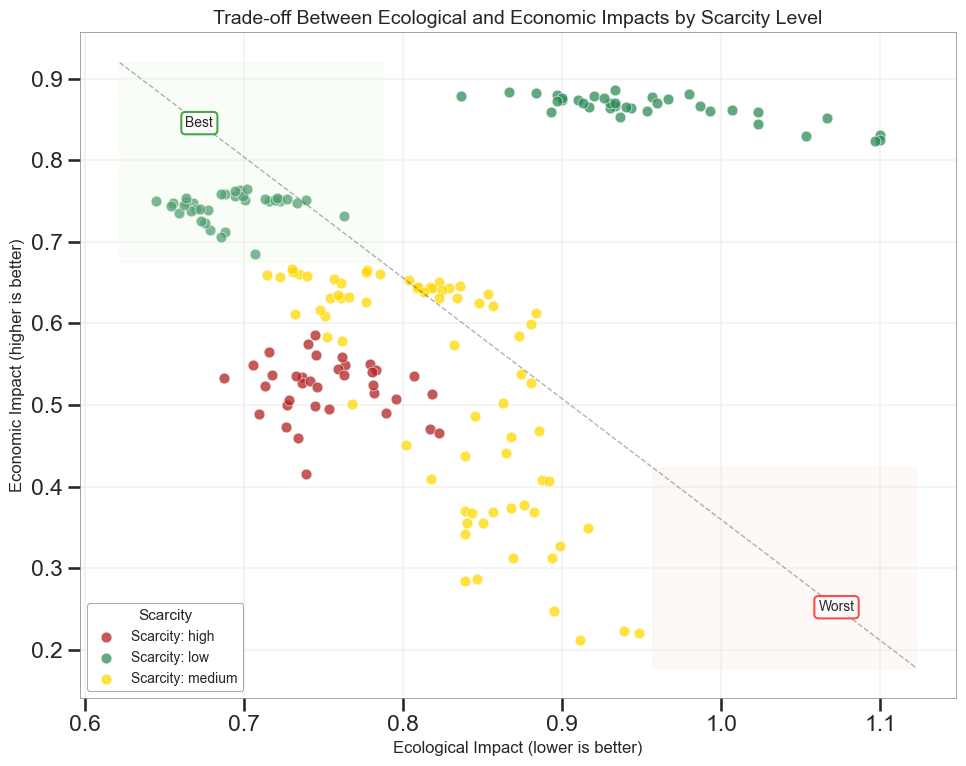

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


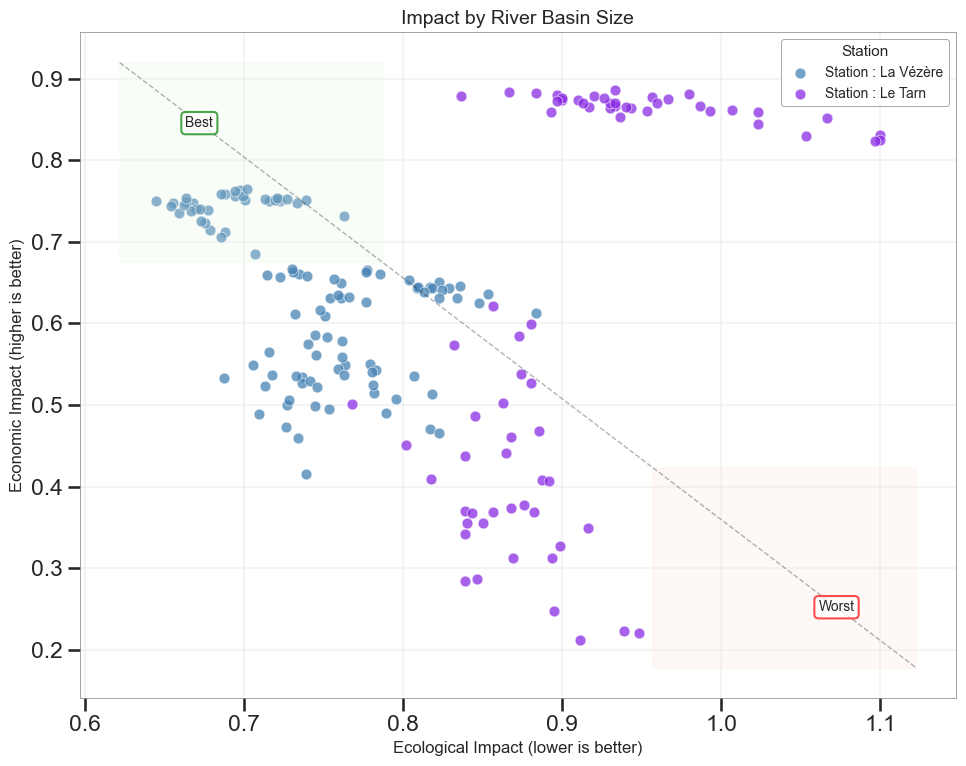

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


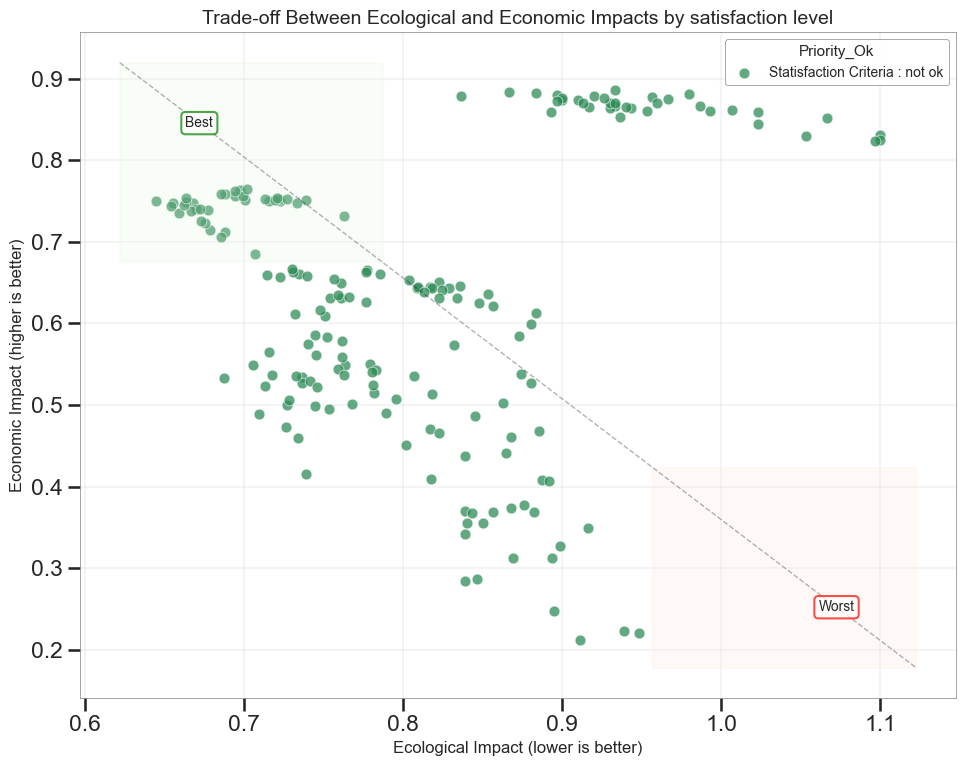

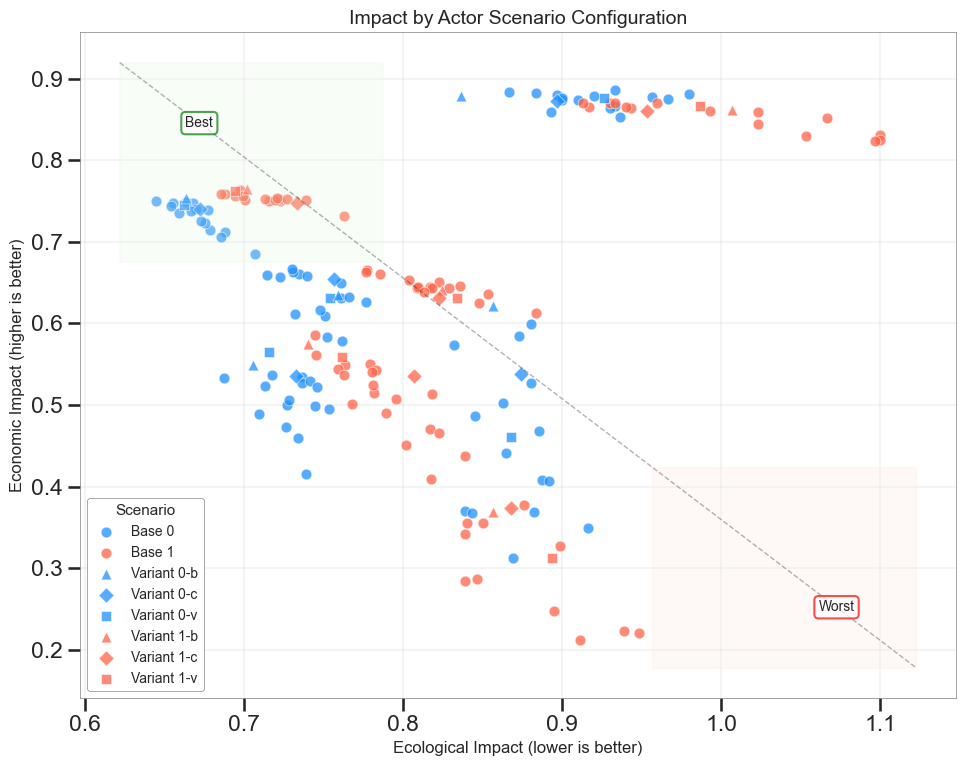

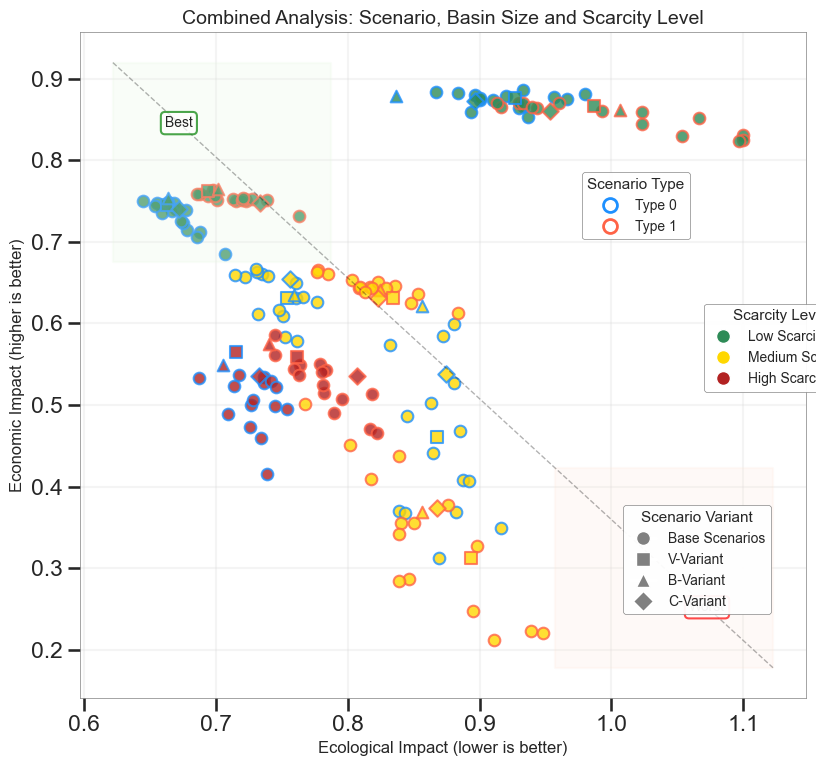

In [136]:
pma.analyze_scenario_impacts(viz_df, is_scalled=True)

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


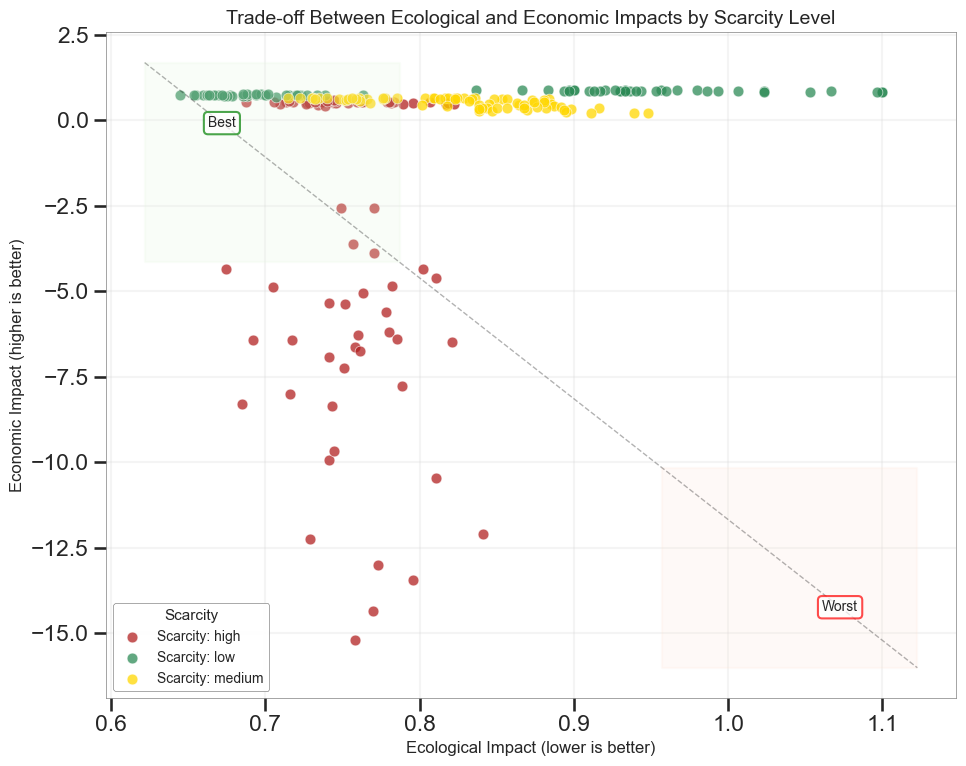

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


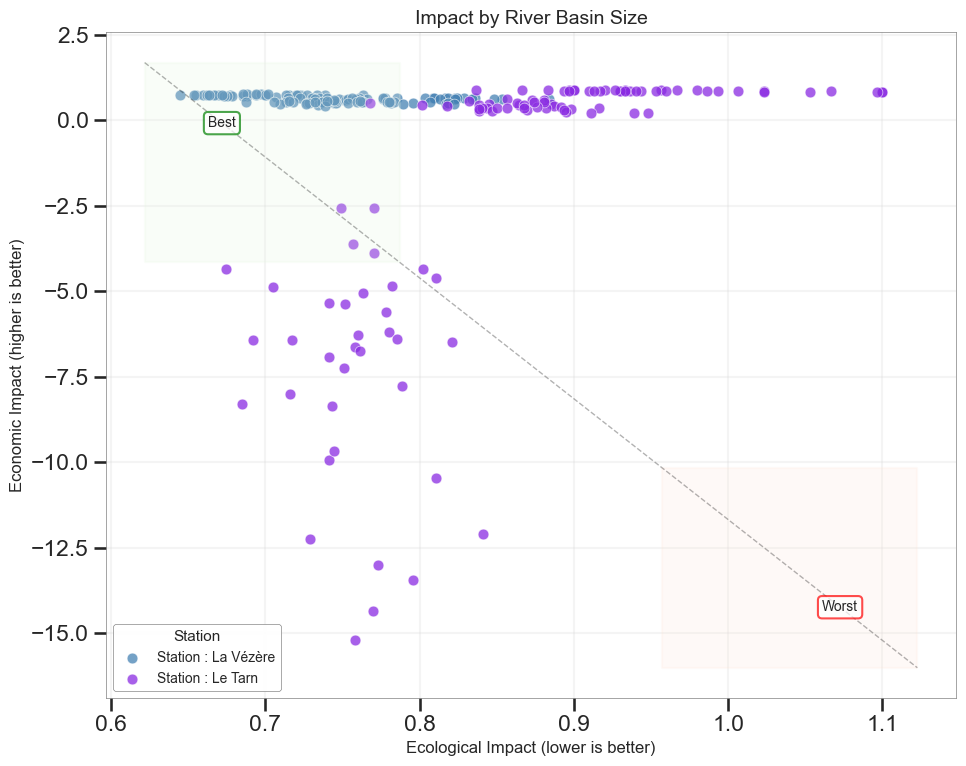

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


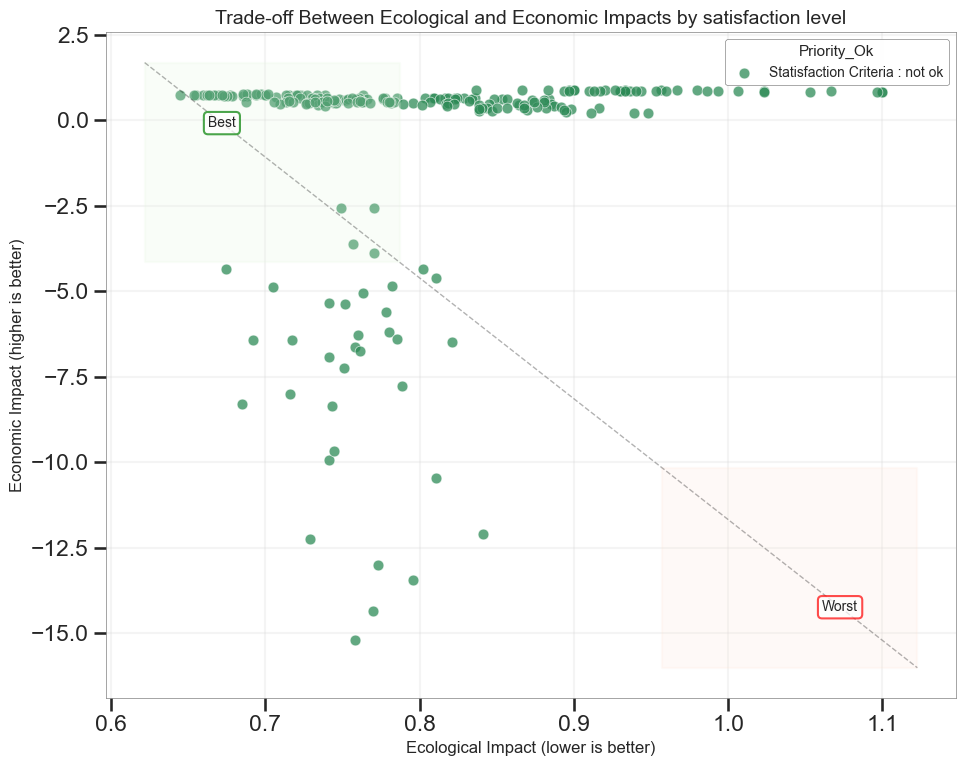

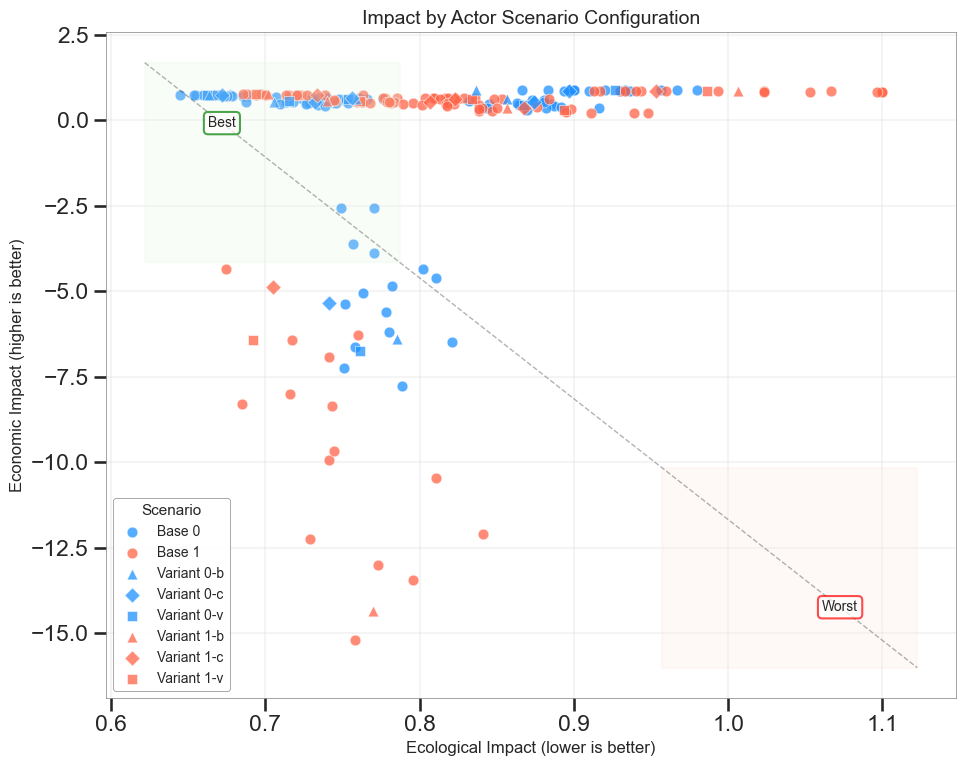

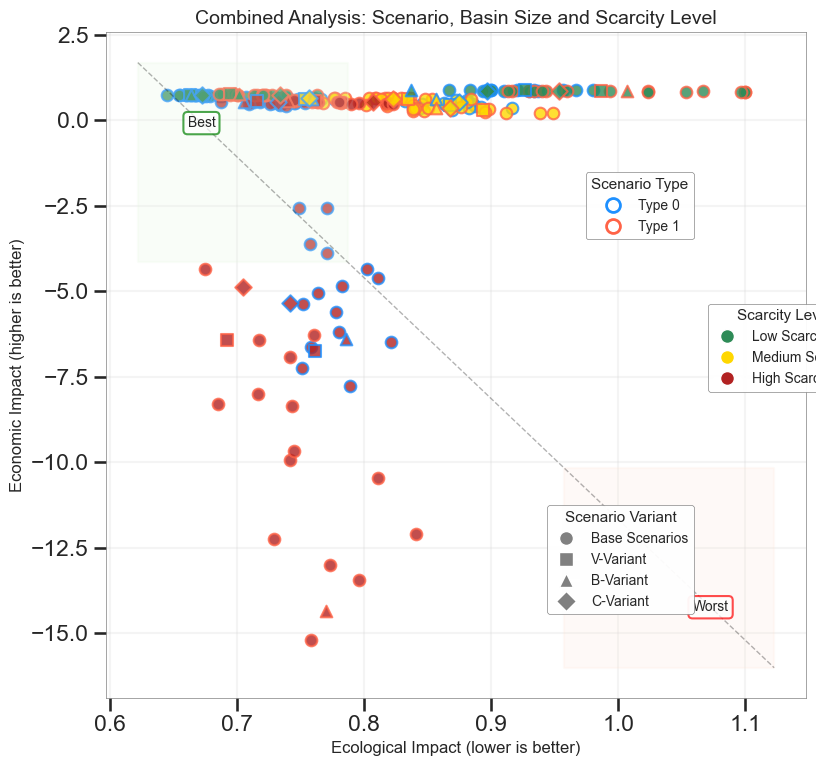

In [137]:
pma.analyze_scenario_impacts(results_df , is_scalled=True)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

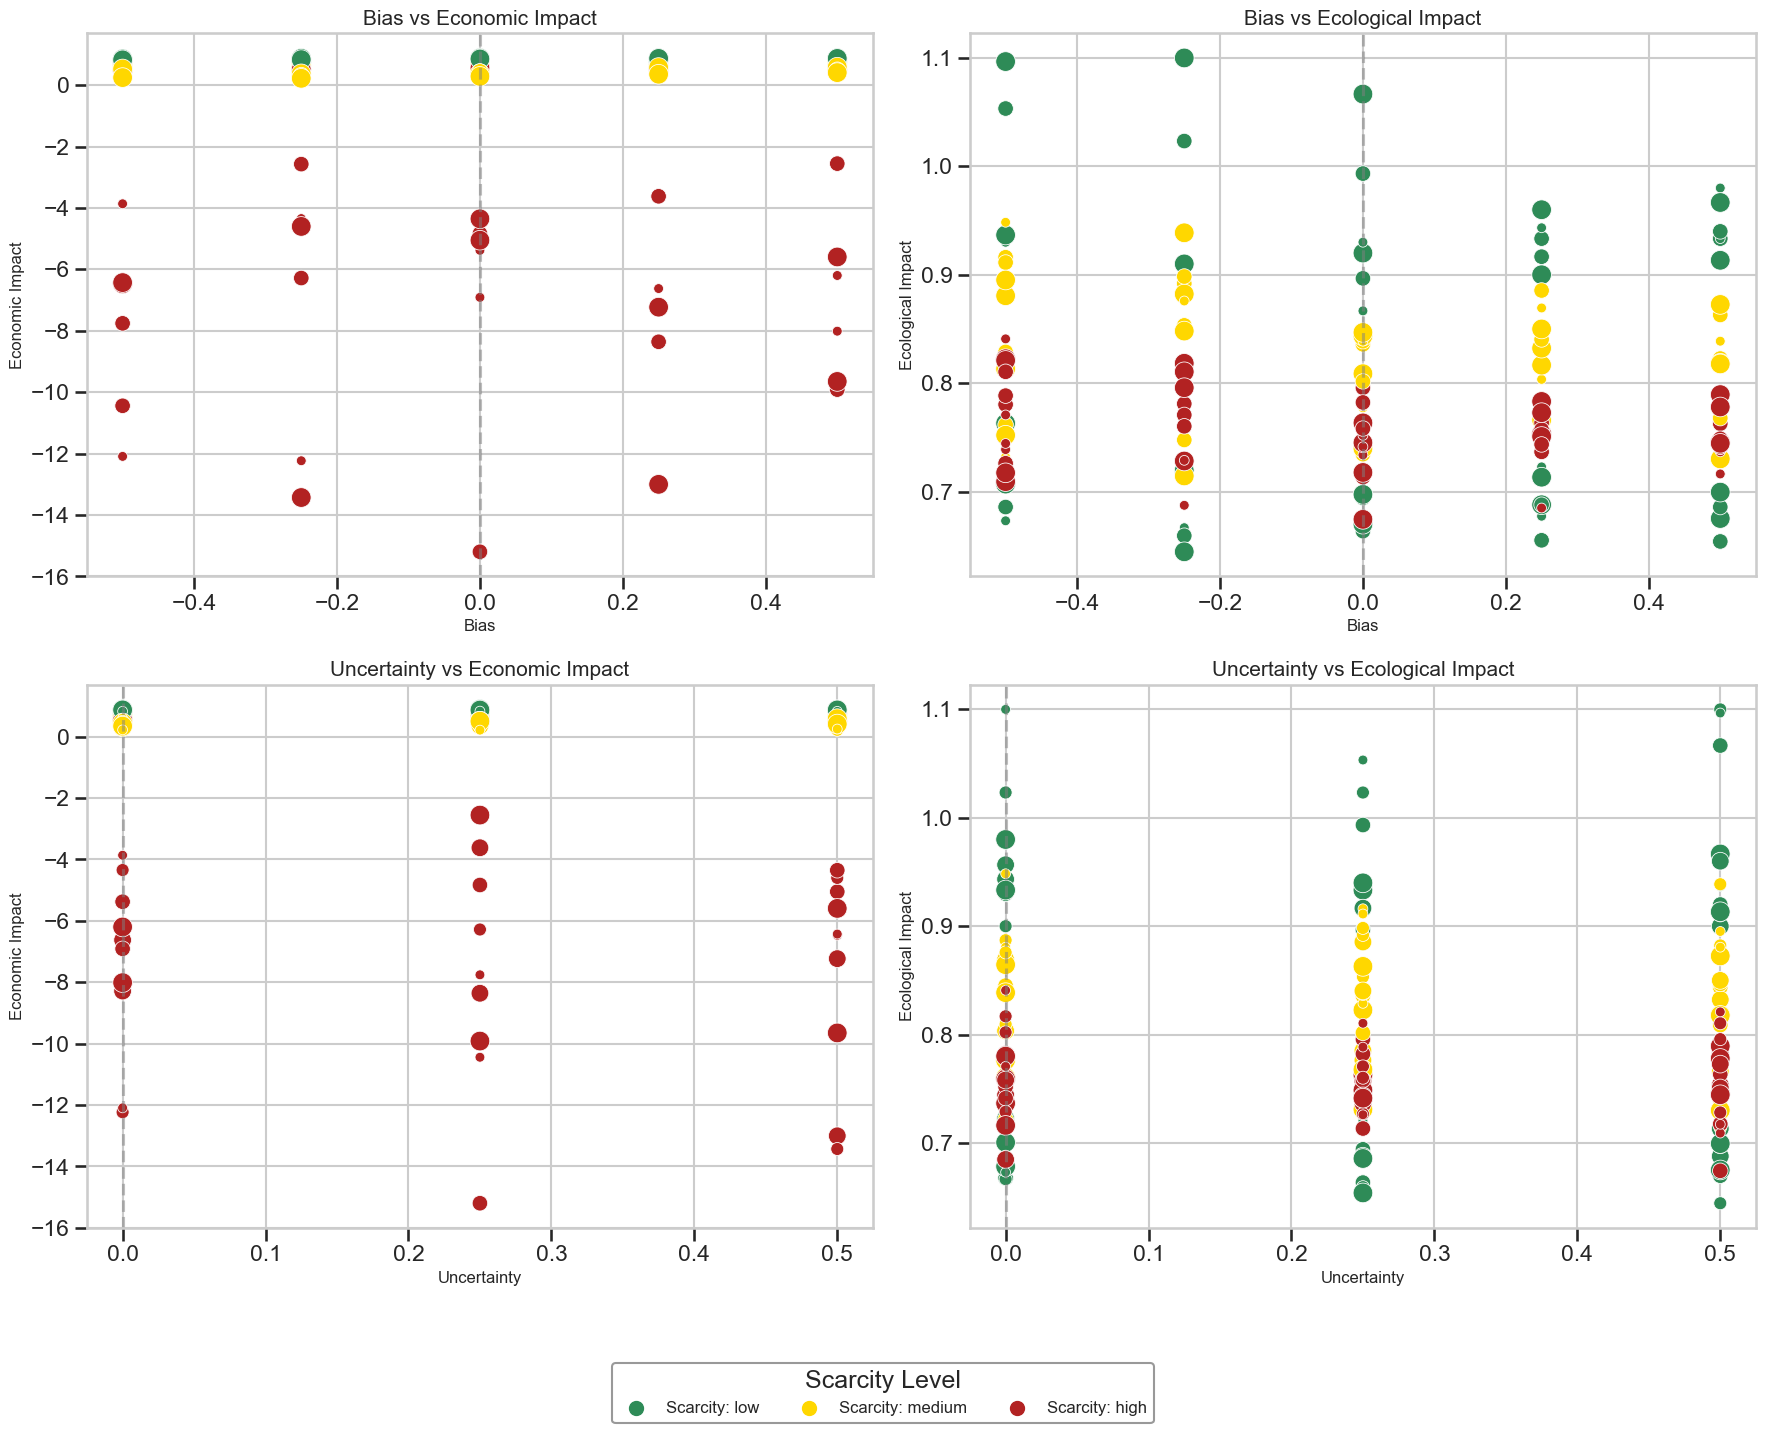

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


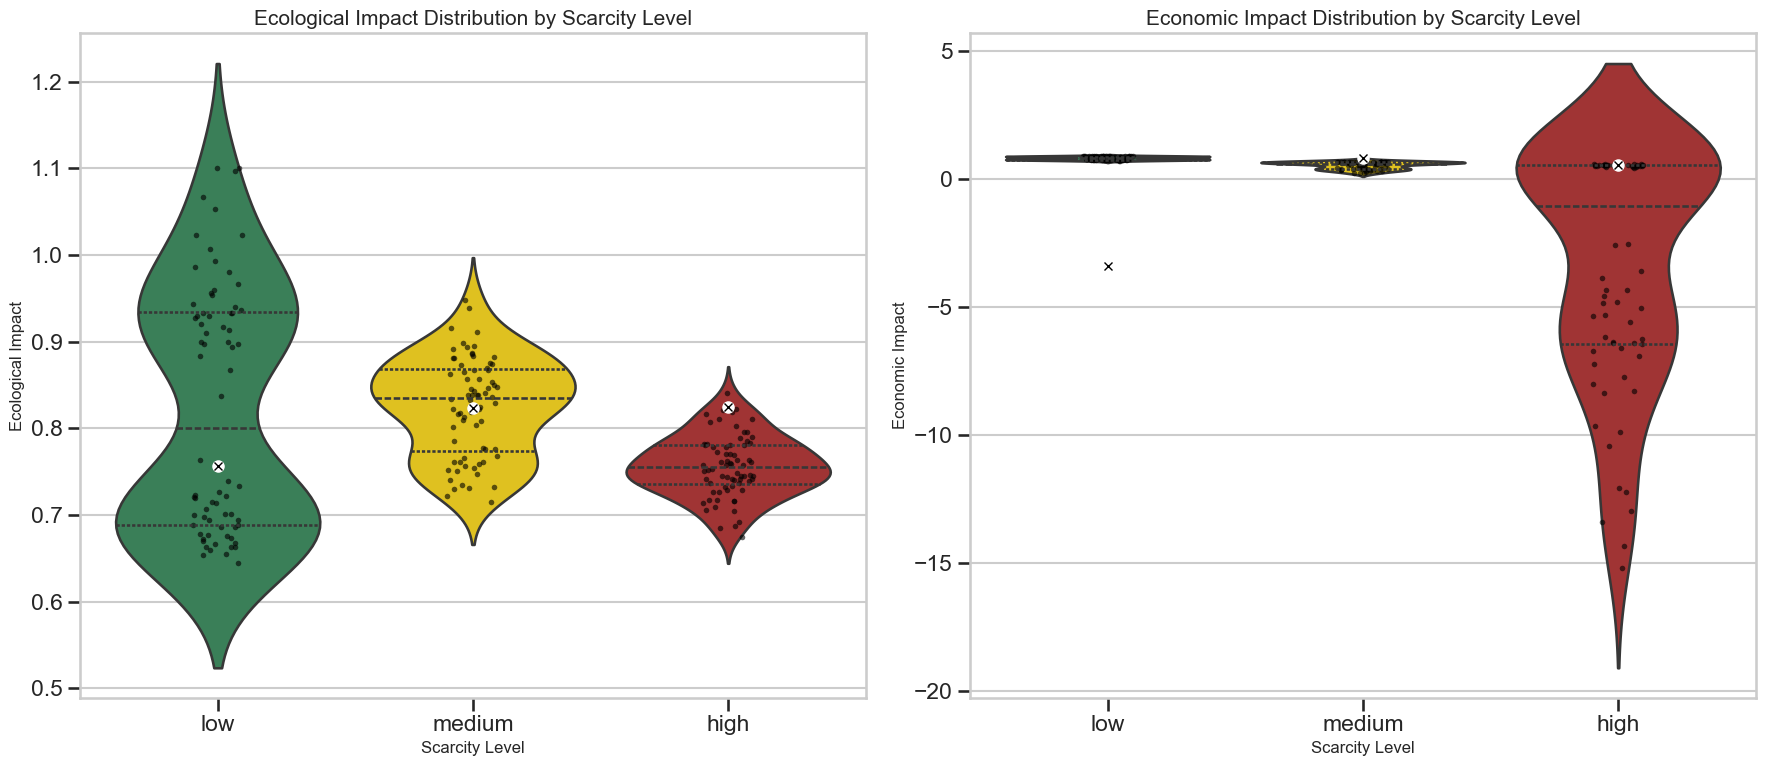

In [138]:
pma.analyze_forecast_effects(results_df, is_scalled=True)

## Correlation Analysis


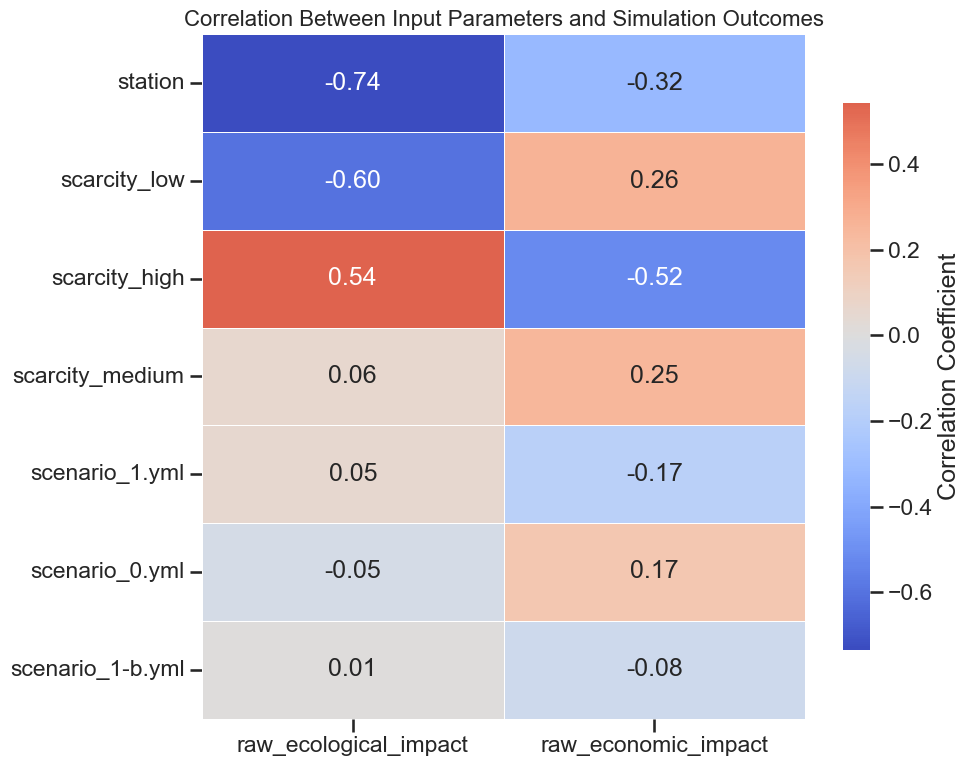


Top impacts on raw_ecological_impact:

Top 5 positive correlations:
  scarcity_high: 0.543
  scarcity_medium: 0.060
  scenario_1.yml: 0.054
  scenario_1-c.yml: 0.012
  uncertainty: 0.009

Top 5 negative correlations:
  scenario_0-b.yml: -0.015
  bias: -0.030
  scenario_0.yml: -0.048
  scarcity_low: -0.603
  station: -0.735

Top impacts on raw_economic_impact:

Top 5 positive correlations:
  scarcity_low: 0.265
  scarcity_medium: 0.251
  scenario_0.yml: 0.169
  scenario_0-c.yml: 0.033
  scenario_0-b.yml: 0.029

Top 5 negative correlations:
  uncertainty: -0.004
  scenario_1-b.yml: -0.081
  scenario_1.yml: -0.175
  station: -0.319
  scarcity_high: -0.516


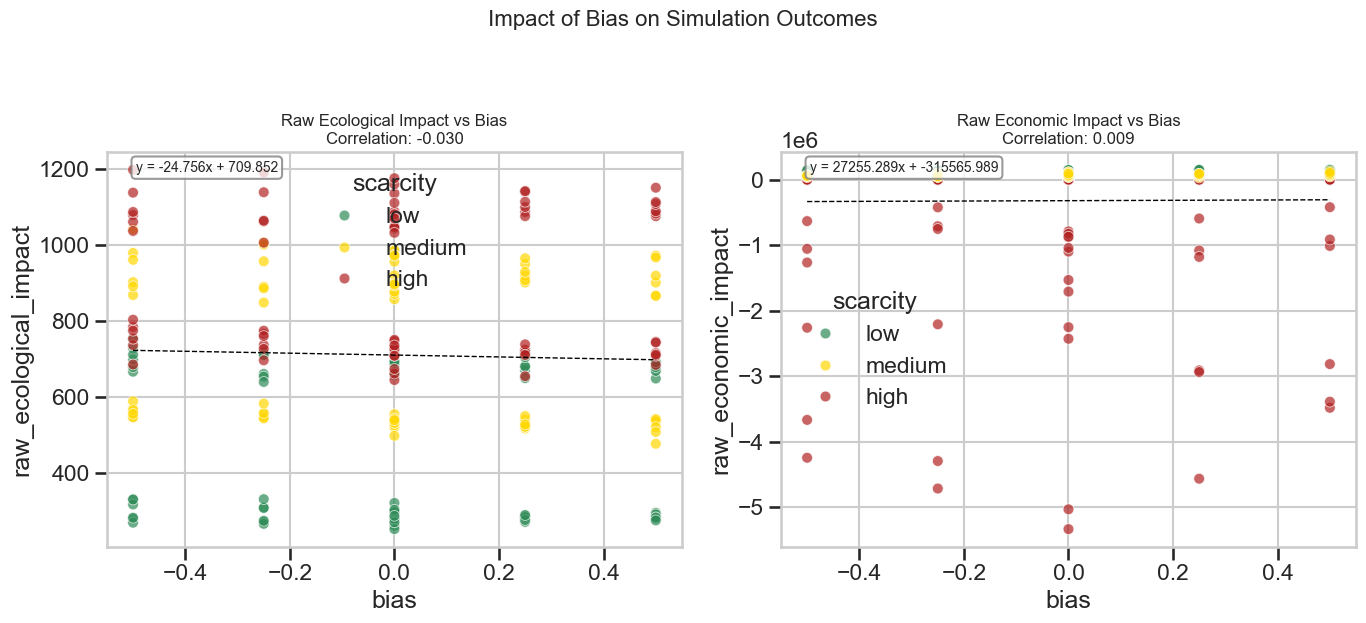

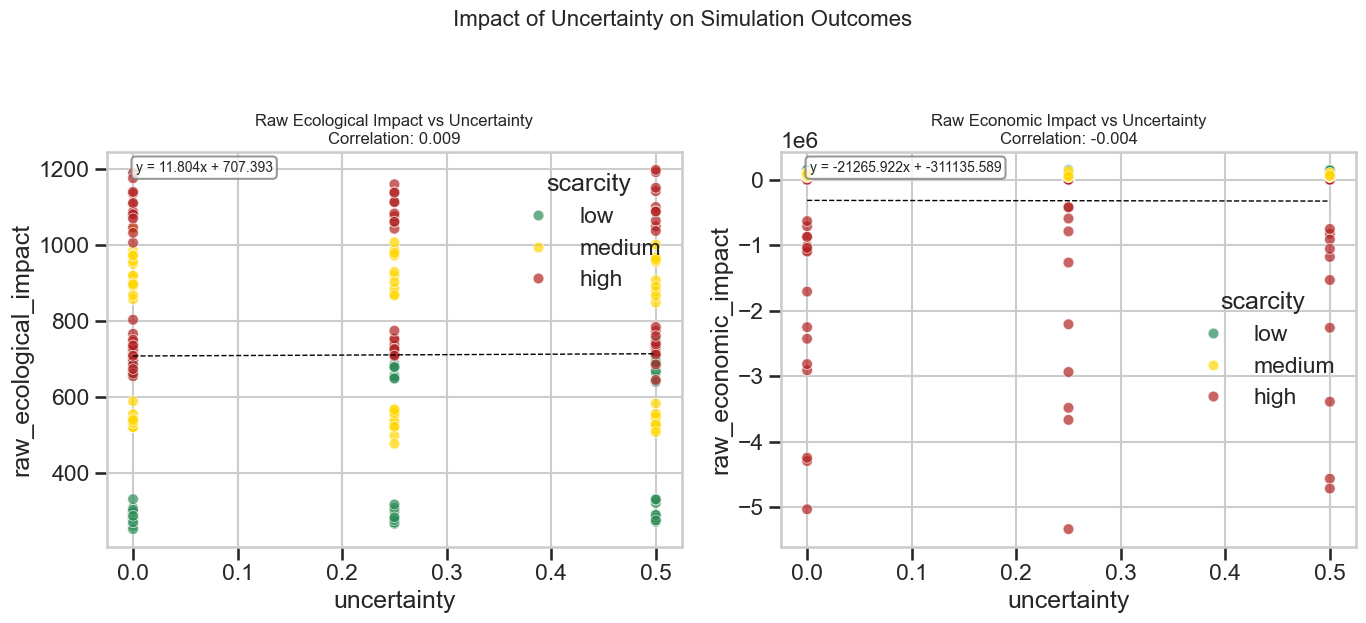

<Figure size 1200x1000 with 0 Axes>

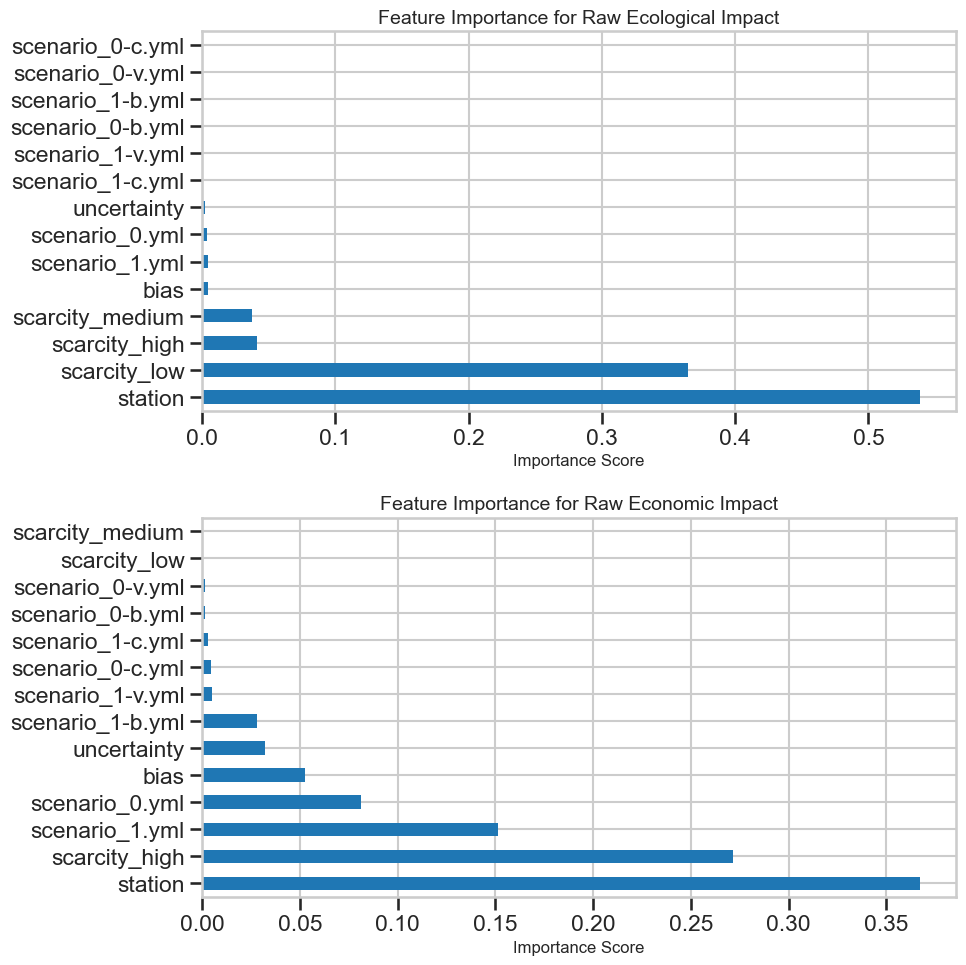

In [139]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:993: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


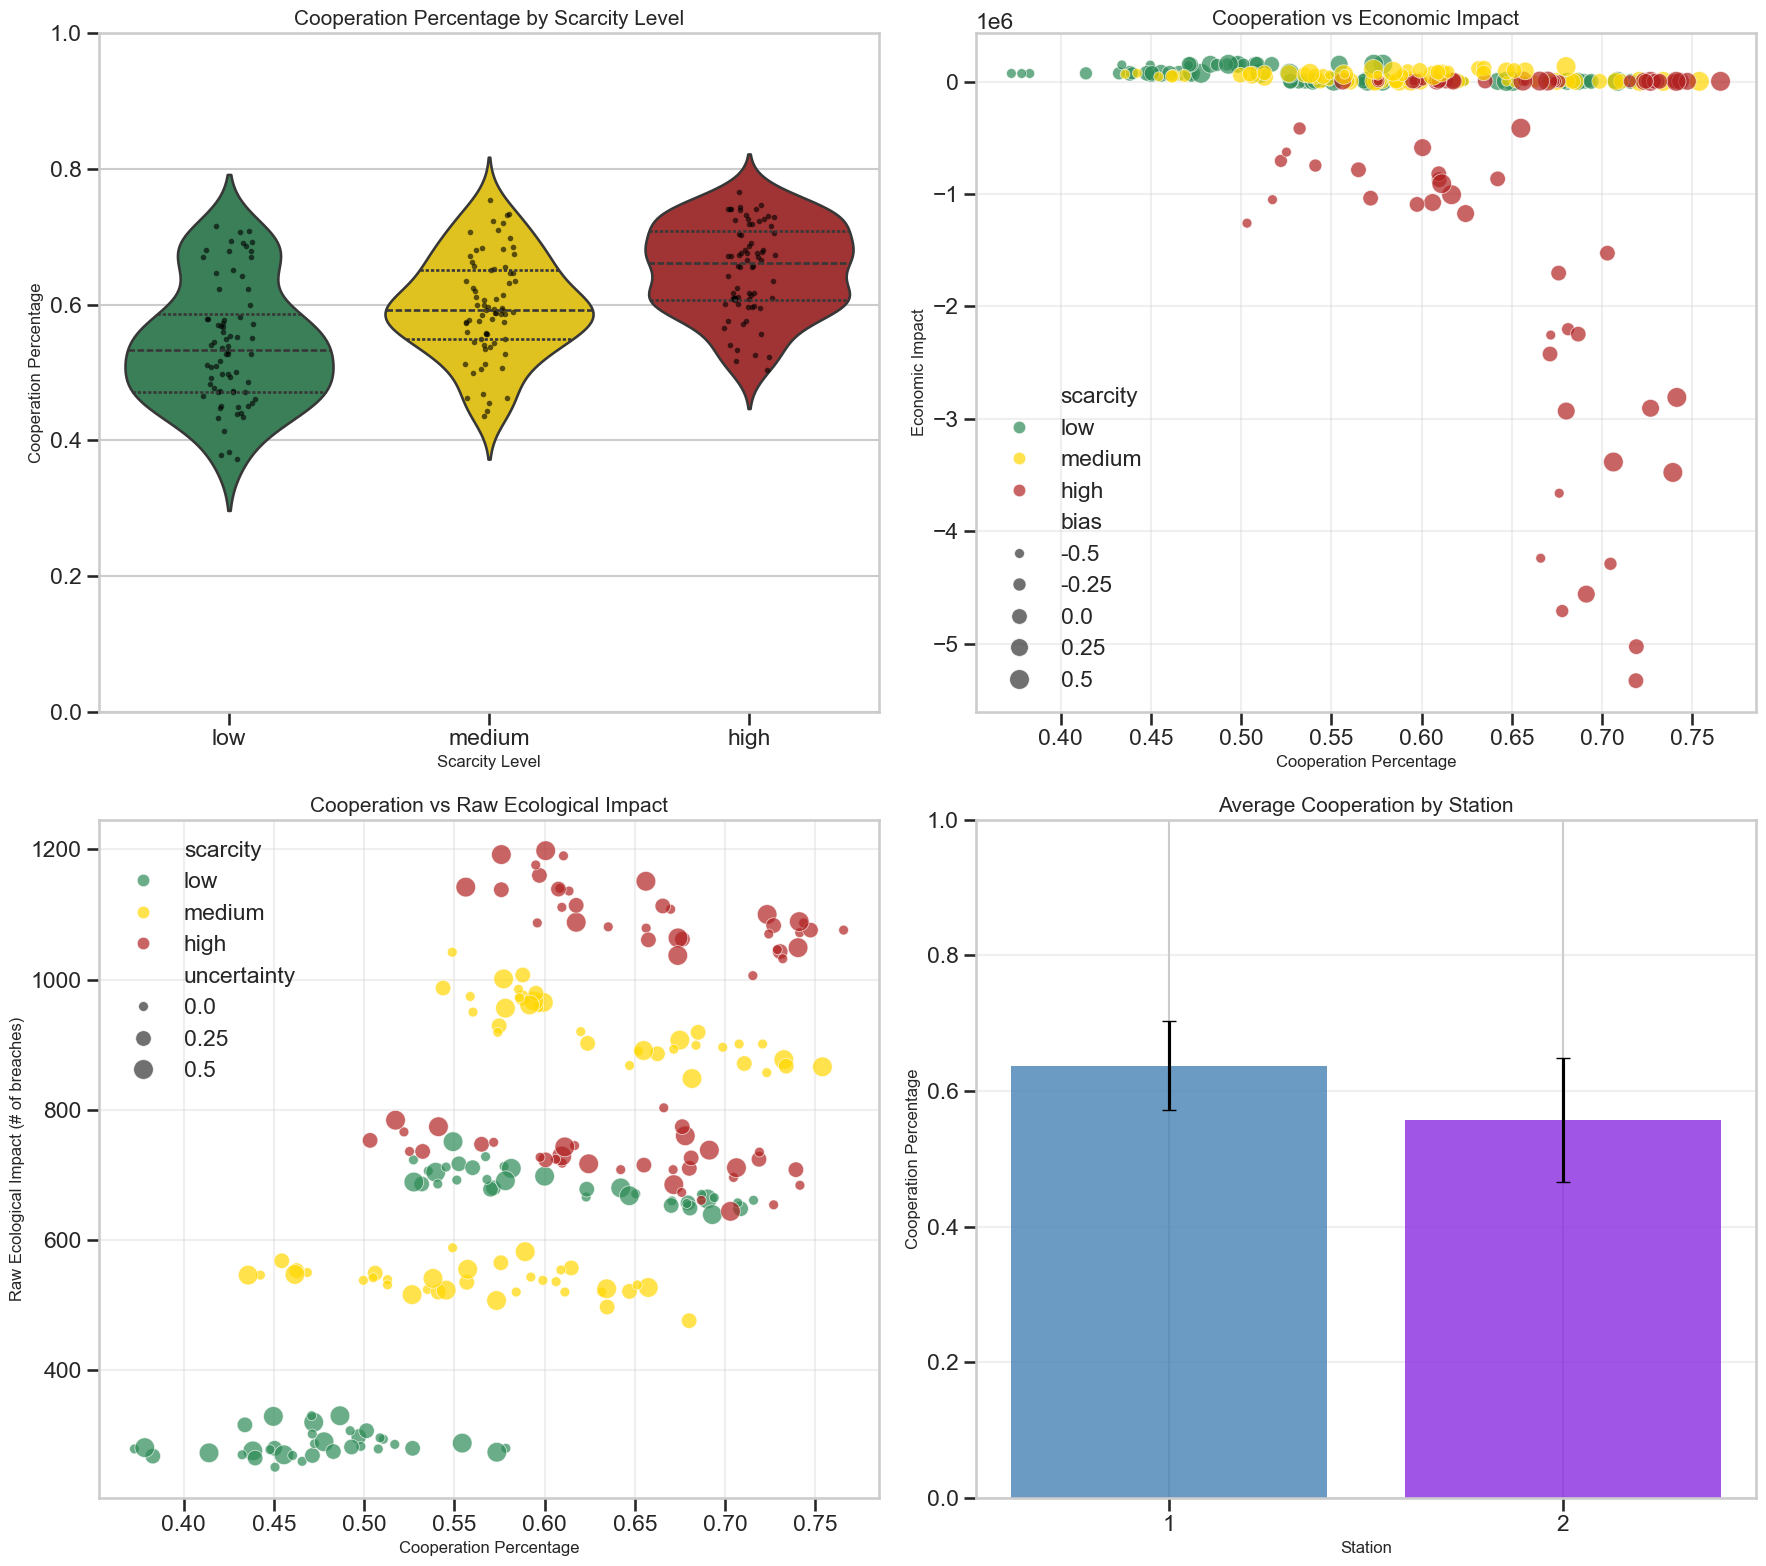

In [140]:
pma.analyze_cooperation_patterns(results_df)

## Raw Impact Vs Scalled Impact
Analyzing the raw (unscaled) ecological / economic impact against scalled impacts 

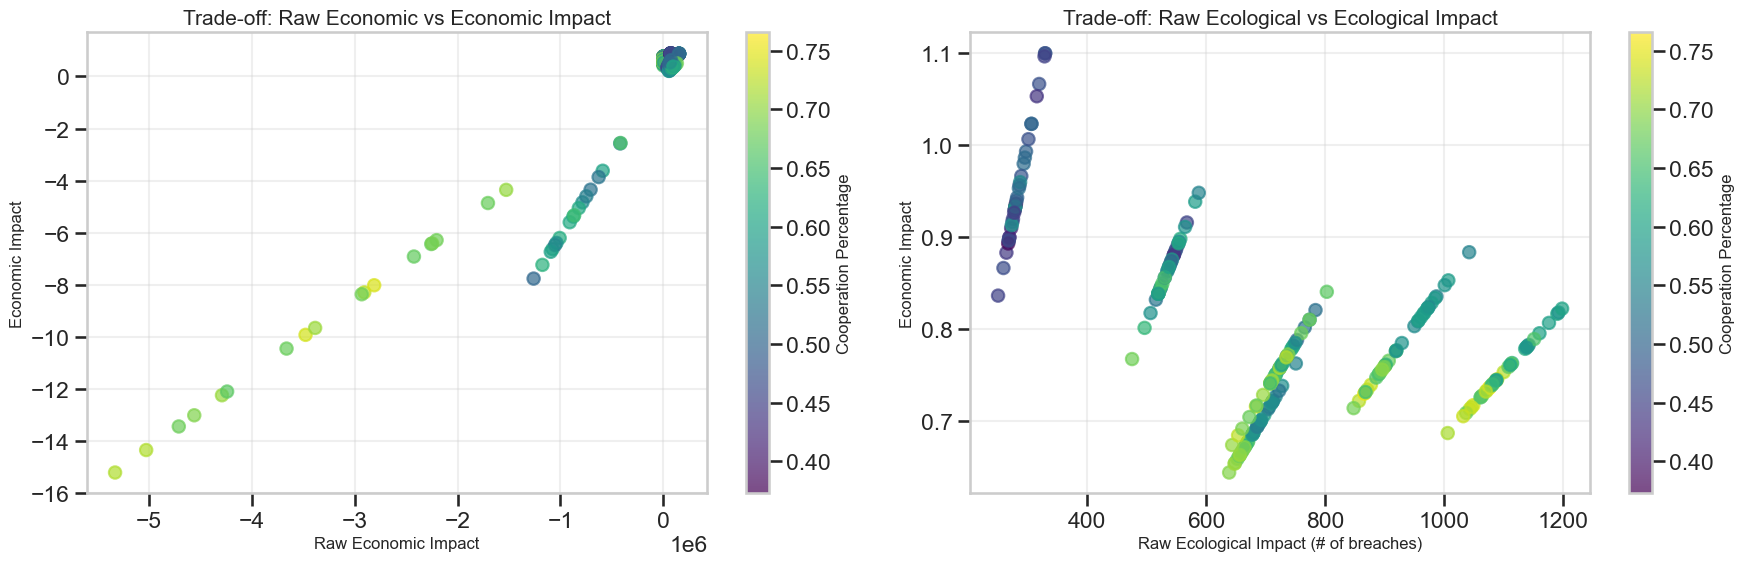

In [141]:
pma.analyze_raw_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


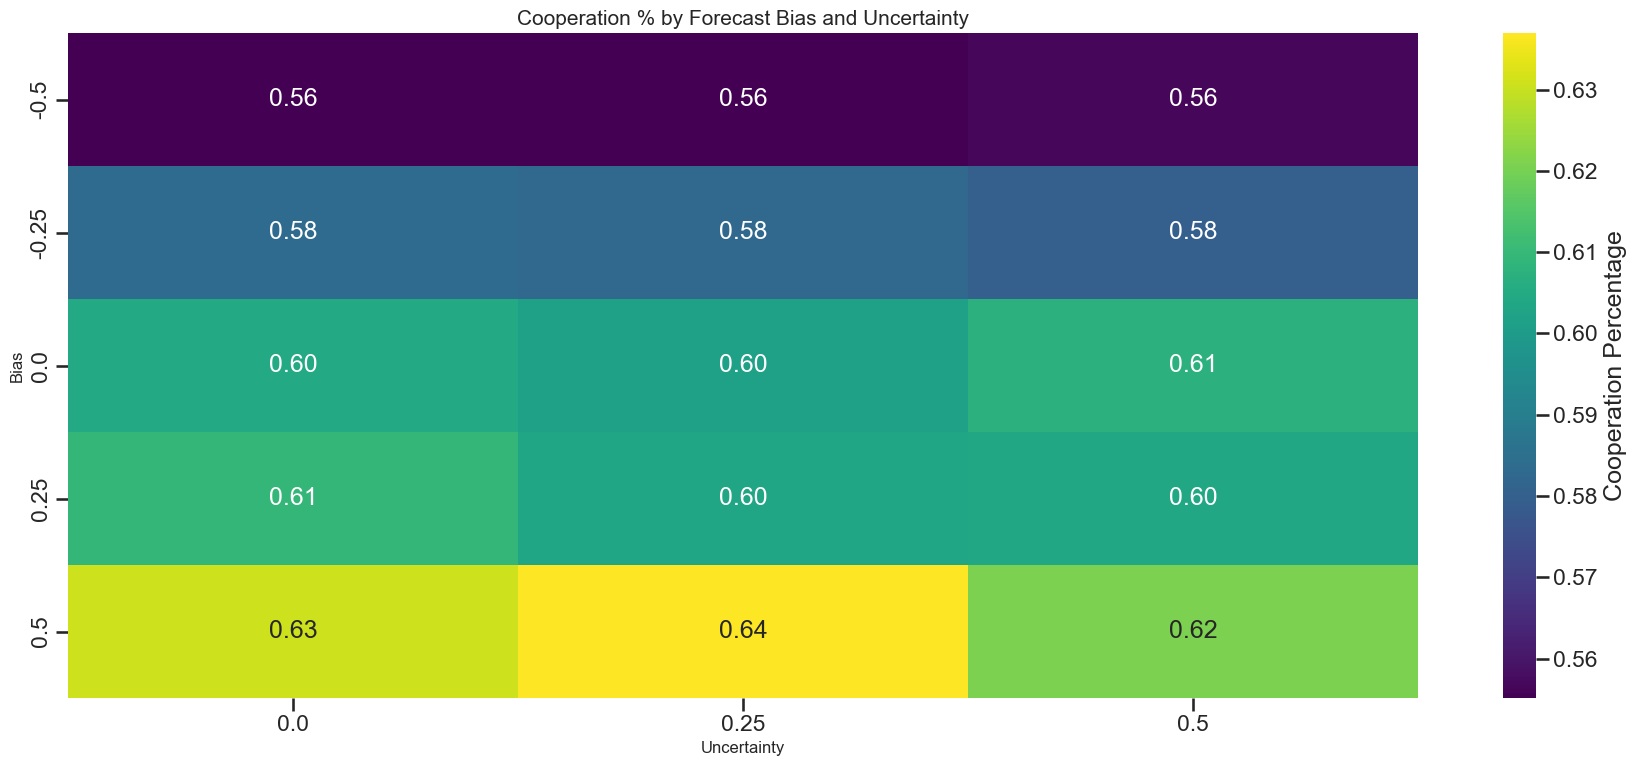

In [142]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.60
Average Raw Ecological Impact: 709.9 breaches
Average Scaled Ecological Impact: 0.802
Average Economic Impact: -315565.989

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.61   
raw_ecological_impact                     0.61                   1.00   
ecological_impact                        -0.70                  -0.59   
economic_impact                          -0.28                  -0.05   
raw_economic_impact                      -0.33                  -0.06   
bias                                      0.25                  -0.03   
uncertainty                              -0.03                   0.01   

                        ecological_impact  economic_impact  \
cooperation_percentage              -0.70            -0.28   
raw_ecological_impact               -0.59            -0.05   
ecological_imp

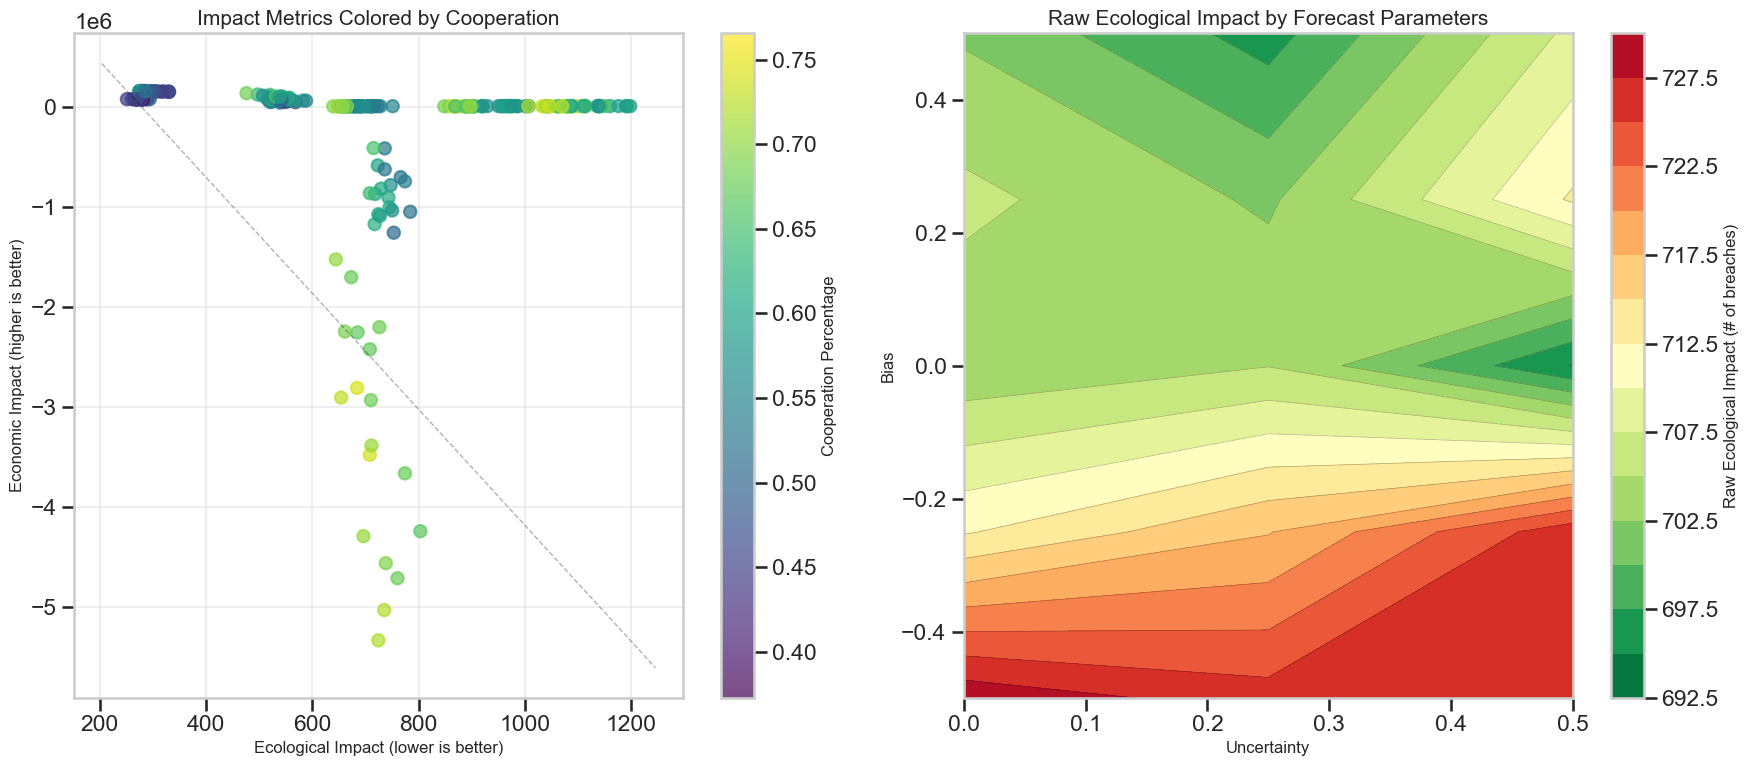

In [143]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!